# Calibration based on One Touch Knock Out Daily Cliquet Options

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.optimize as scpo
import time

pd.reset_option('all')

from functions.BSpricer import BS_Pricer
from functions.MERTONpricer import Merton_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

Let's initialize the values found in StockAnalysis module: scale factors for otko option prices and spx values.

In [2]:
scale_factors = {
    'TSLA': 10.35,
    'META': 6.23,
    'AAPL': 7.84
}

spx_data = pd.read_csv('data/SPX_data.csv')
print(spx_data.head(6))

         Date         Open         High          Low        Close      Volume
0  2016-01-20  1876.180054  1876.180054  1812.290039  1859.329956  6416070000
1  2016-01-21  1861.459961  1889.849976  1848.979980  1868.989990  5078810000
2  2016-01-22  1877.400024  1908.849976  1877.400024  1906.900024  4901760000
3  2016-01-25  1906.280029  1906.280029  1875.969971  1877.079956  4401380000
4  2016-01-26  1878.790039  1906.729980  1878.790039  1903.630005  4357940000
5  2016-01-27  1902.520020  1916.989990  1872.699951  1882.949951  4754040000


Let's retrieve the prices for One Touch Knock Out options on the SPX.

In [3]:
otko_spx = pd.read_csv('data\otko_prices_spx.csv')
print(f'Otko Prices: \n')
print(otko_spx.head())
SPX_S0 = spx_data.loc[spx_data['Date'] == '2016-01-20', 'Close'].values[0]
print(f'\n SPX Closing Value on 20/01/2016:', round(SPX_S0, 2))

Otko Prices: 

  Starting date Stock Name Expiry  K1  K2      BID      ASK
0    20/01/2016        SPX     6M  75   0  0.0850%  0.1000%
1    20/01/2016        SPX     6M  70   0  0.0400%  0.0500%
2    20/01/2016        SPX     6M  85  75  0.1700%  0.2000%
3    20/01/2016        SPX     6M  80  70  0.1200%  0.1400%
4    20/01/2016        SPX     6M  90  80  0.2400%  0.2700%

 SPX Closing Value on 20/01/2016: 1859.33


### Visualize payoffs of OTKO contracts

The BID(%) and ASK(%) prices are in percentages. This means that the protection buyer pays the $bid(%) * S0$ when acquiring the option, while the seller receives the $ask(%) * S0$.

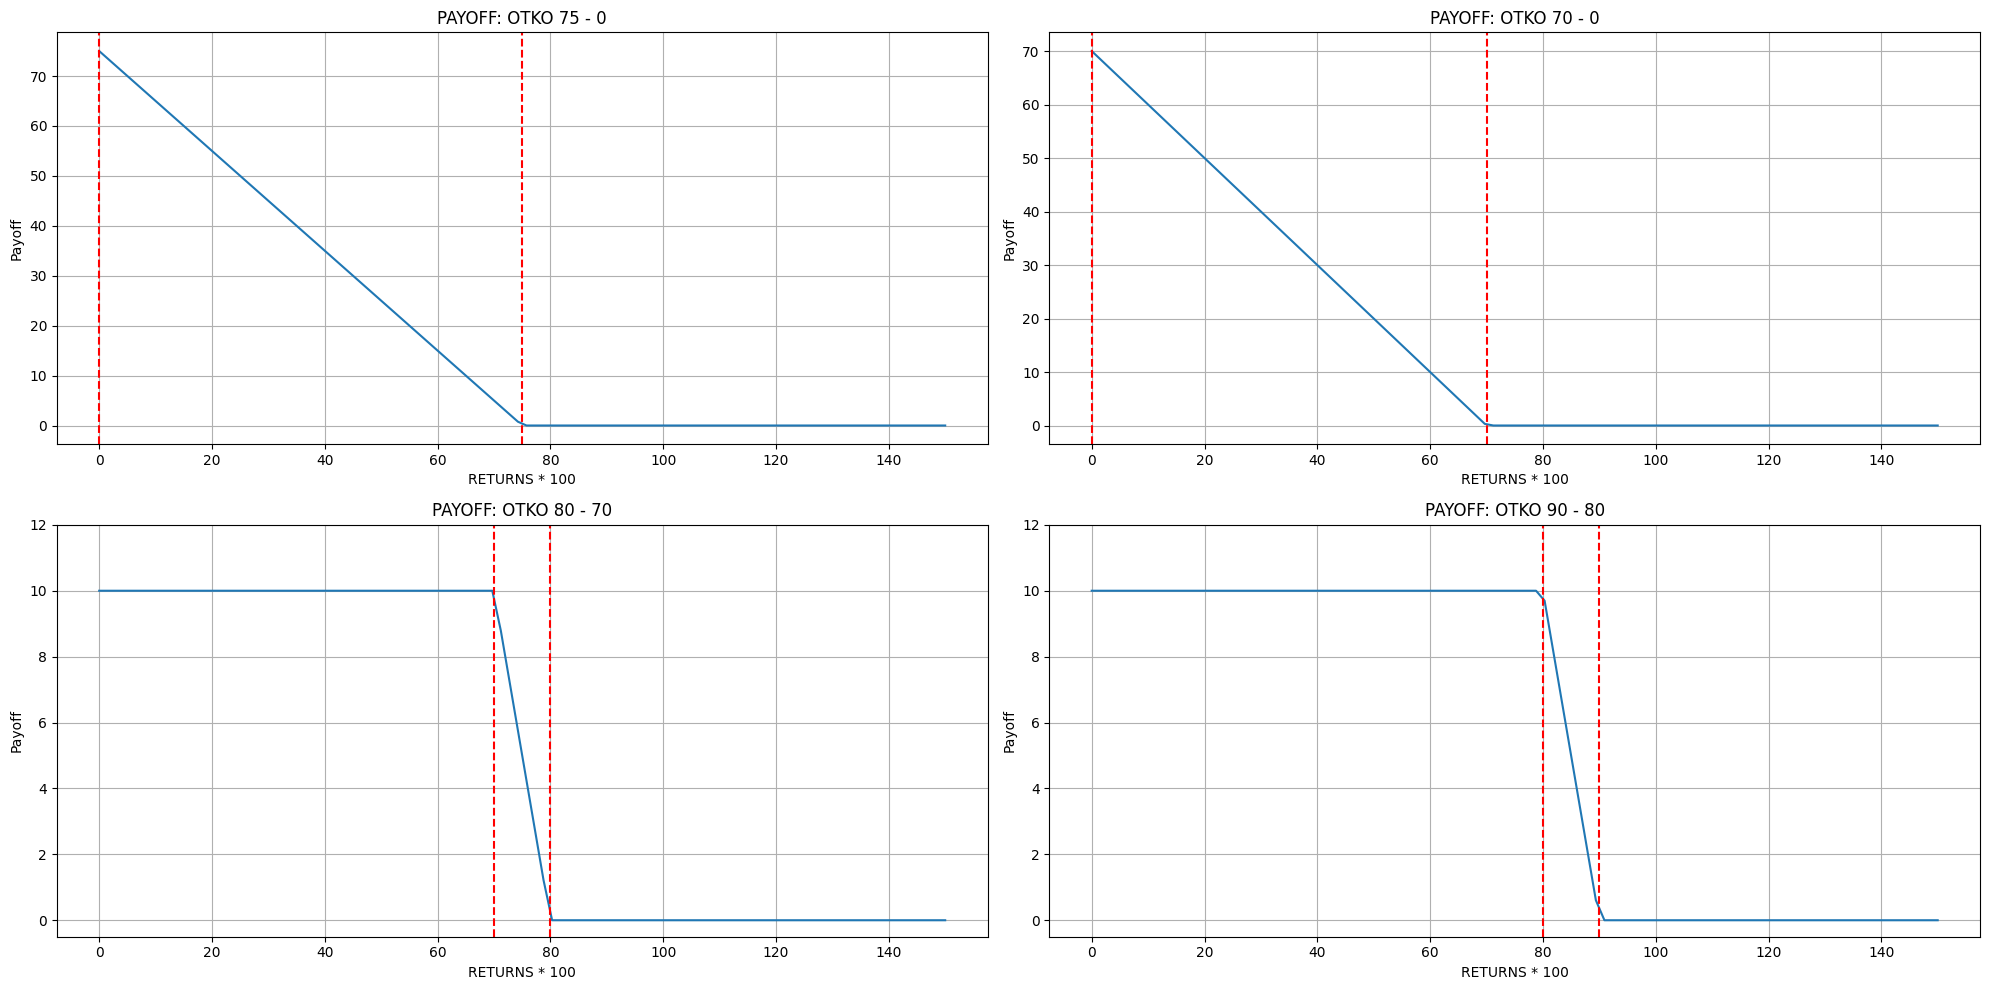

In [4]:
def otko_payoff(R, K1, K2):
    # R: Rendimento St/St-1 * 100
    # K2: Barriera di knock out
    # K1: Barriera di one touch
    # payoff_value: Valore del payoff quando l'opzione è attiva

    payoffs = []
    for Rt in R:
        if Rt > K1:
            payoffs.append(0)
        elif K2 < Rt <= K1:
            payoffs.append((K1 - Rt))
        elif Rt <= K2:
            payoffs.append((K1-K2))
    return payoffs

R = np.linspace(0,150,100)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
row = 0
col = 0

for index, contract in otko_spx.iterrows():
    if index != 2:  # Exclude the 2nd row (index 1)
        K1 = contract['K1']
        K2 = contract['K2']
        axes[row, col].plot(R, otko_payoff(R, K1, K2))
        axes[row, col].set_xlabel('RETURNS * 100')
        axes[row, col].set_ylabel('Payoff')
        axes[row, col].set_title(f'PAYOFF: OTKO {K1} - {K2}')
        if index != 0 and index!= 1:
            axes[row, col].set_ylim(-0.5, 12)
        axes[row, col].grid()
        # Add vertical lines for K1 and K2 (dashed)
        axes[row, col].axvline(x=K1, color='red', linestyle='--')
        axes[row, col].axvline(x=K2, color='red', linestyle='--')
        col += 1
        if col == 2:
            row += 1
            col = 0

plt.tight_layout()
plt.show()


#### Refactoring dataset

In [5]:
# Remove the percentage symbol and convert the columns to float
otko_spx['BID'] = otko_spx['BID'].str.rstrip('%').astype(float)
otko_spx['ASK'] = otko_spx['ASK'].str.rstrip('%').astype(float)

# Rename the columns
otko_spx.rename(columns={'BID': 'BID(%)', 'ASK': 'ASK(%)'}, inplace=True)

otko_spx['Midpoint (%)'] = otko_spx['BID(%)'] + (abs(otko_spx['BID(%)'] - otko_spx['ASK(%)']) / 2)

otko_spx.to_csv('data/otko_spx_6m.csv')
print(otko_spx)

  Starting date Stock Name Expiry  K1  K2  BID(%)  ASK(%)  Midpoint (%)
0    20/01/2016        SPX     6M  75   0   0.085    0.10        0.0925
1    20/01/2016        SPX     6M  70   0   0.040    0.05        0.0450
2    20/01/2016        SPX     6M  85  75   0.170    0.20        0.1850
3    20/01/2016        SPX     6M  80  70   0.120    0.14        0.1300
4    20/01/2016        SPX     6M  90  80   0.240    0.27        0.2550


## One Touch Knock Out daily Cliquets Option Pricing

In [6]:
S0 = spx_data.loc[0, 'Close']
r = 0.05
T = 0.5
q = 0
exercise = 'european'
symbol = 'SPX'
paths = 1000
days = 126

th_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'Midpoint (%)': otko_spx['Midpoint (%)']
})

th_mc_prices = pd.DataFrame({})
th_cf_prices = pd.DataFrame({})

strikes = otko_spx[['K1', 'K2']].values / 100

### Black and Scholes Model

Black and Scholes SPX value after 252 days: 1866.1688101753484


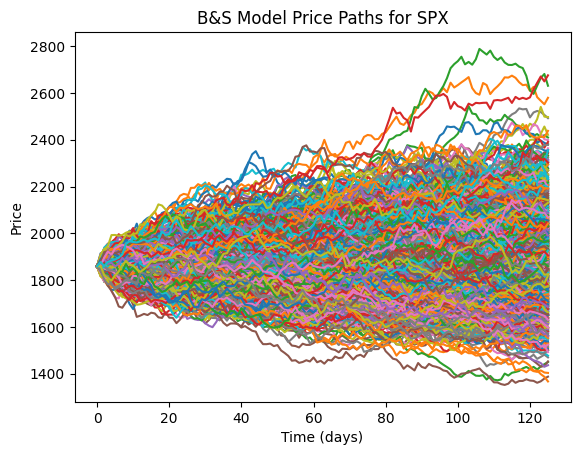

<Figure size 1000x600 with 0 Axes>

In [7]:
sigma = 0.1447  # vola from weighted calibration
BS = BS_Pricer(S0, r, q, sigma, T, exercise, None)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)
avg_final_value = SBlackScholes[20,:].mean()
print(f'Black and Scholes SPX value after 252 days: {avg_final_value}')

In [8]:
# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SBlackScholes.T:
        payoffs.append(BS.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

bs_mc_prices = np.zeros(len(th_prices))
for index in range(len(th_prices)):
    bs_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] *100

th_prices['B&S MC (%)'] = bs_mc_prices
print(th_prices)

   K1  K2  Midpoint (%)  B&S MC (%)
0  75   0        0.0925         0.0
1  70   0        0.0450         0.0
2  85  75        0.1850         0.0
3  80  70        0.1300         0.0
4  90  80        0.2550         0.0


### Merton Model
Let's retrieve first the parameters calibrated with the plain vanilla option prices. They are used to find prices of the **One-Touch KnockOut Daily Cliquet** options, which serve as a benchmark for calibration.

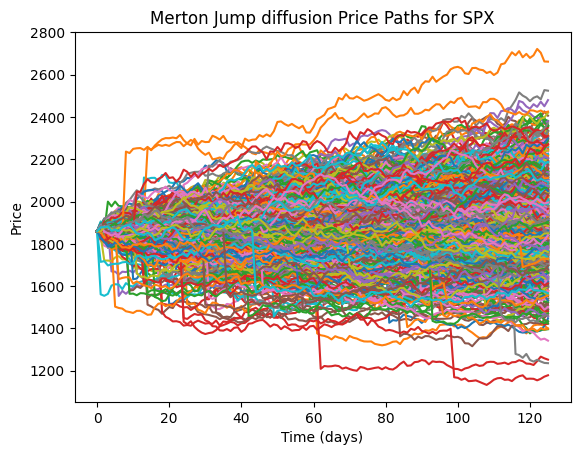

<Figure size 1000x600 with 0 Axes>

In [9]:
# calibrated params from plain vanilla options
mert_params = [0.1248, 0.61, -0.08, 0.1]
#mert_params = [0.0878, 0.9085, -0.118, 0.0963]

sigma, lambd, meanJ, stdJ = mert_params
MERT = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
SMerton = MERT.MertonPath(days, paths)
MERT.plotMertonPath(SMerton, symbol)  # Plot all paths


In [10]:
avg_final_value = SMerton[-1,:].mean()
print(f'Merton Jump Diffusion SPX value after 252 days: {avg_final_value}')

Merton Jump Diffusion SPX value after 252 days: 1898.556416677022


In [11]:
# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton.T:
        returns = path[1:] / path[:-1]
        payoffs.append(MERT.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))
    print(avg_payoffs)

merton_mc_prices = np.zeros(len(th_prices))

for index in range(len(th_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100

print(merton_mc_prices)
th_prices['MERTON MC (%)'] = merton_mc_prices
th_mc_prices['MERTON MC (%)'] = merton_mc_prices
# print(th_prices)


[6.936532233406956e-07]
[6.936532233406956e-07, 0.0]
[6.936532233406956e-07, 0.0, 0.0017180235976675298]
[6.936532233406956e-07, 0.0, 0.0017180235976675298, 0.00025106365495381887]
[6.936532233406956e-07, 0.0, 0.0017180235976675298, 0.00025106365495381887, 0.005693992864560152]
[6.76526864e-05 0.00000000e+00 1.67560544e-01 2.44864871e-02
 5.55340768e-01]


### Kou Jump Diffusion model

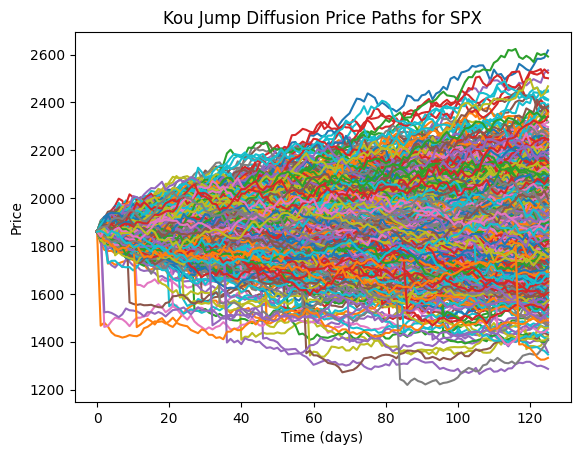

<Figure size 1000x600 with 0 Axes>

In [12]:
# calibrated params
kou_params =[0.1233, 0.2608, 0.1961, 6.2507, 6.1967]
#kou_params = [0.07, 0.9296, 0.2498, 13.0534, 6.5574]
sigma, lambd, p, eta1, eta2 = kou_params
KOU = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, None)
SKou = KOU.KouPath(days, paths)
KOU.plotKouPath(SKou, symbol)  # Plot all paths

In [13]:
avg_final_value = SKou[-1,:].mean()
print(f'KOU Jump Diffusion SPX value after 252 days: {avg_final_value}')

KOU Jump Diffusion SPX value after 252 days: 1906.0641574203717


In [14]:
# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou.T:
        payoffs.append(KOU.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(th_prices))
for index in range(len(th_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100

th_prices['KOU MC (%)'] = kou_mc_prices
th_mc_prices['KOU MC (%)'] = kou_mc_prices
# print(th_prices)

### Variance Gamma Model

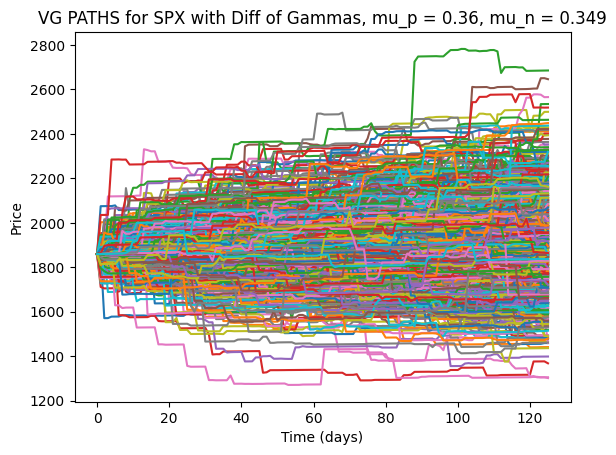

<Figure size 800x600 with 0 Axes>

In [15]:
# calibrated params
vg_params = [0.151, 0.0107, 0.0909]
sigma, theta, nu = vg_params
VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, None)
SVarGamma= VG.VarianceGammaPath2(days, paths)
VG.plotVGPath(SVarGamma, symbol, 'Diff of Gammas')  # Plot all paths

In [16]:
avg_final_value = SVarGamma[-1,:].mean()
print(f'KOU Jump Diffusion SPX value after 252 days: {avg_final_value}')

KOU Jump Diffusion SPX value after 252 days: 1903.9357974224356


In [17]:
# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma.T:
        payoffs.append(VG.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(th_prices))
for index in range(len(th_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]*100

th_prices['VG MC (%)'] = vg_mc_prices
th_mc_prices['VG MC (%)'] = vg_mc_prices
# print(th_prices)

In [18]:
tmp = [0, 0, 0, 0, 0.011779784036436092]
mean = np.mean(tmp)
print(mean)
price = mean * np.exp(-r*T)
price2 = price* 100
print(price2)
#pd.options.display.max_columns = 4
print(th_prices.iloc[:,:4])
print(th_mc_prices.to_string(index=False))

0.002355956807287218
0.22977880264578482
   K1  K2  Midpoint (%)  B&S MC (%)
0  75   0        0.0925         0.0
1  70   0        0.0450         0.0
2  85  75        0.1850         0.0
3  80  70        0.1300         0.0
4  90  80        0.2550         0.0
 MERTON MC (%)  KOU MC (%)  VG MC (%)
      0.000068    0.000000   0.000000
      0.000000    0.000000   0.000000
      0.167561    0.228366   0.010540
      0.024486    0.032077   0.000000
      0.555341    0.498371   0.115551


### Monte Carlo vs Closed Forms prices
Let's now compare otko prices obtained by Monte carlo simulations with those obtained by closed form solutions.

In [19]:
lambd = 0.429; meanJ = 0.01; stdJ = 0.206; r = 3.36/100; sigma = 0.1848
tol = 1e-6
K1 = 0.80; K2 = 0.70

phi1 = ss.norm.cdf(np.log(K1), meanJ , stdJ)
phi2 = ss.norm.cdf(np.log(K2+tol), meanJ, stdJ)
phi4 = ss.norm.cdf(np.log(K1) -  stdJ**2, meanJ, stdJ)
phi5 = ss.norm.cdf(np.log(K2+tol) - stdJ**2, meanJ, stdJ)
# print(f'phi1: {phi1}, con K1 = {K1}, K2 = {K2}')
# print(f'phi2: {phi2}, phi3: {phi2}, phi4: {phi4}, phi5: {phi5}')
den = r + lambd * phi1
num = (1 - np.exp(-1 * den))
Int = lambd * (K1*phi1 - K2*phi2 - (np.exp(meanJ + stdJ**2 / 2) * (phi4 - phi5)))

print(phi1, '\n', phi2, '\n',phi4,'\n', phi5,'\n', Int)

print('res: ', Int*num/den)


print(den)
print(num)
print(0.34 / Int)

0.1288666625024873 
 0.037540556260431054 
 0.0904865579111665 
 0.023518409670391184 
 0.003313255430080821
res:  0.0031702754577372532
0.08888379821356704
0.08504811355883546
102.61810692684999


#### Merton Jump Diffusion model

In [20]:
merton_prices_cf = np.zeros(len(th_prices))
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    merton_prices_cf[i] = MERT.closed_formula_otko(K1/100, K2/100)

th_prices['MERTON CF (%)'] = merton_prices_cf
th_cf_prices['MERTON CF (%)'] = merton_prices_cf
# print(th_prices)

In [21]:
eta_m = 0.129; lambdap =0.302; beta = np.log(0.85)
phi3= lambdap * np.exp(beta/eta_m)
x = (0.0055 *(1+eta_m)/(lambdap*eta_m))**(eta_m/(1+eta_m))
I = lambdap*eta_m / (1+eta_m) * (0.85 **(1+(1/eta_m)) - 0.75 **(1+(1/eta_m)))

print(phi3,'\n', I, '\n', x)

val = (3.36/100+ phi3)
closed_form = I * (1-np.exp(-1*val))/val *100
print(closed_form)

0.08567750918682397 
 0.005538541593892537 
 0.8107234818886105
0.5220980334915348


#### Kou Jump diffusion model

In [22]:
kou_prices_cf = np.zeros(len(th_prices))
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    kou_prices_cf[i] = KOU.closed_formula_otko(K1/100, K2/100)

th_prices['KOU CF (%)'] = kou_prices_cf
th_cf_prices['KOU CF (%)'] = kou_prices_cf
# print(th_prices)

#### Variance Gamma process

In [23]:
vg_prices_cf = np.zeros(len(th_prices))
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    vg_prices_cf[i] = VG.closed_formula_otko5(K1/100, K2/100)

th_prices['VG CF (%)'] = vg_prices_cf
th_cf_prices['VG CF (%)'] = vg_prices_cf
# print(th_prices)

In [24]:
print(th_prices.iloc[:, :4])
print('\n', th_mc_prices.to_string(index=False))
print('\n',th_cf_prices.to_string(index=False))

   K1  K2  Midpoint (%)  B&S MC (%)
0  75   0        0.0925         0.0
1  70   0        0.0450         0.0
2  85  75        0.1850         0.0
3  80  70        0.1300         0.0
4  90  80        0.2550         0.0

  MERTON MC (%)  KOU MC (%)  VG MC (%)
      0.000068    0.000000   0.000000
      0.000000    0.000000   0.000000
      0.167561    0.228366   0.010540
      0.024486    0.032077   0.000000
      0.555341    0.498371   0.115551

  MERTON CF (%)  KOU CF (%)  VG CF (%)
      0.015029    0.179877   0.000132
      0.001744    0.109815   0.000012
      0.257701    0.260208   0.012122
      0.076623    0.175974   0.001318
      0.612826    0.374935   0.104620


### Calibration of model parameters
The following code snippet perfoms calibration of the models parameters using closed forms.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i },$$ $P_i$ are the market prices and $f$ is the pricing function, $f$ given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. The optimization problem is carried out using the module *least_squares* of the library `scipy.optimize`.
Let's define the spread first.

In [25]:
spreads =  otko_spx['ASK(%)'] - otko_spx['BID(%)']
# print(spreads)
mkt_prices = otko_spx['Midpoint (%)'].values
#print(strikes)

#### Merton Jump Diffusion

In [26]:
x0 = mert_params       # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 0, -2, 0], [2, 2, 1, 5] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = 0
    for k in range(len(strikes)):
        sq_err +=  spreads[k]*(M.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices), bounds=bounds, method = 'trf', verbose=1)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

`gtol` termination condition is satisfied.
Function evaluations 215, initial cost 8.9134e-06, final cost 2.6413e-10, first-order optimality 9.61e-09.


In [27]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.1248 	 12.48%
> Calibrated Jump intensity [λ] =  0.6
> Calibrated Jump Mean =  0.191
> Calibrated Jump St. dev.  =  0.266
TIME ELAPSED:  0.87 sec


In [28]:
print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> European CALLS:\t {mert_params}')
print(f'> OTKO DC:\t\t\t {mert_params_calibrated}')

CALIBRATED PARAMETERS [σ		λ		m		v]
> European CALLS:	 [0.1248, 0.61, -0.08, 0.1]
> OTKO DC:			 [0.1248, 0.6038, 0.1911, 0.2659]


##### Visualize paths with the calibrated parameters

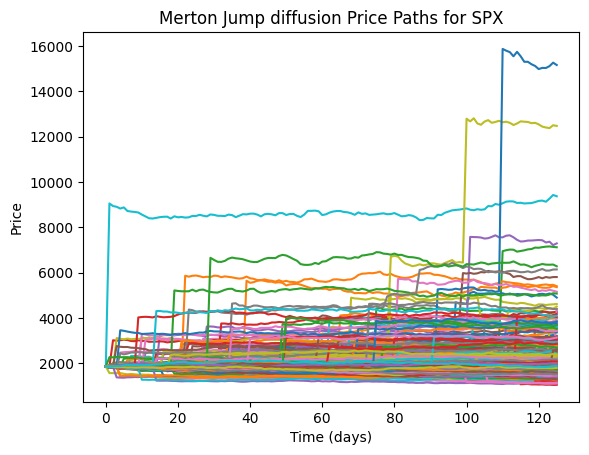

<Figure size 1000x600 with 0 Axes>

In [29]:
sigma_c, lambd_c, meanJ_c, stdJ_c = mert_params_calibrated
MERT_CAL = Merton_pricer(S0, None, T, r, q, sigma_c, lambd_c, meanJ_c, stdJ_c, exercise)
SMerton_CAL = MERT_CAL.MertonPath(days, paths)
MERT_CAL.plotMertonPath(SMerton_CAL, symbol)  # Plot all paths

#### Kou Jump diffusion model

In [147]:
x0 =  [0.0847, 0.1, 0.4, 2.15, 4]    # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-3, 1e-2, 0, 0, 0], [np.inf, 5, 0.9, 10, 15] )

# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = 0
    for k in range(len(strikes)):
        sq_err += spreads*(KOU.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1)
end2=time.time()

kou_params_calibrated = [round(p,4) for p in kou2.x[:5]]

The maximum number of function evaluations is exceeded.
Function evaluations 500, initial cost 5.3469e-07, final cost 9.7871e-10, first-order optimality 1.25e-08.


In [148]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.0847 	 8.47%
> Calibrated Jump intensity [λ] =  0.28
> Calibrated Upward Jump probability [p] = 0.42, [q] = 0.58
> Calibrated Rate of Exp. 1  [η_1] =  2.15
> Calibrated Rate of Exp. 2  [η_2] =  6.84
TIME ELAPSED:  1.18 sec


In [149]:
print(f'CALIBRATED PARAMETERS: [σ\t\tλ\t\tp\t\tη1\t\tη2]')
print(f'> European CALLS:\t {kou_params}')
print(f'> OTKO DC:\t\t\t {kou_params_calibrated}')

CALIBRATED PARAMETERS: [σ		λ		p		η1		η2]
> European CALLS:	 [0.1233, 0.2608, 0.1961, 6.2507, 6.1967]
> OTKO DC:			 [0.0847, 0.2768, 0.424, 2.15, 6.8376]


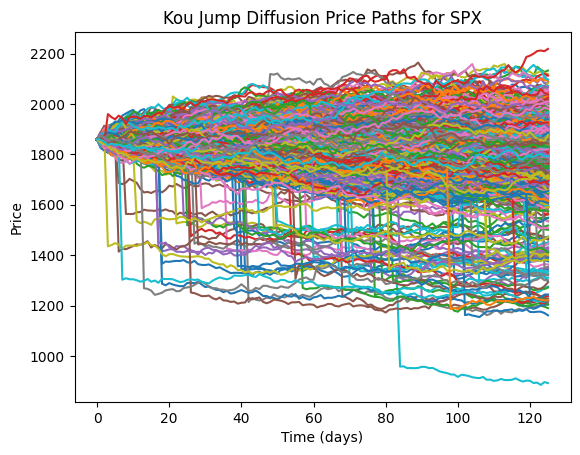

<Figure size 1000x600 with 0 Axes>

In [150]:
sigma, lambd, p, eta1, eta2 = kou_params_calibrated
KOU_CAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
#KOU = Kou_pricer(S0, None, T, r, 0.23, 7.04, 0.985,0.0765,0.0414, S0)

SKou_cal = KOU_CAL.KouPath(days, paths)
# Plot all paths
KOU_CAL.plotKouPath(SKou_cal, symbol)

#### Variance Gamma process model

In [151]:
x0 = [0.22, -0.10, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-3, -5, 0], [3, 5, 10] )

def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    sq_err = 0
    for k in [0,1,2,3]:
        sq_err += spreads*(VG.closed_formula_otko5(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

The maximum number of function evaluations is exceeded.
Function evaluations 300, initial cost 2.6708e-07, final cost 2.5759e-08, first-order optimality 5.09e-07.


In [152]:
print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.2193, 	 21.93%
> Calibrated mean rate gamma process [θ] =  0.1255
> Calibrated variance rate gamma process [v]=  0.9877
TIME ELAPSED:  1.18 sec


In [153]:
print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> European CALLS:\t {vg_params}')
print(f'> OTKO DC:\t\t\t {vg_params_calibrated}')

CALIBRATED PARAMETERS: [σ 		θ		 v]
> European CALLS:	 [0.151, 0.0107, 0.0909]
> OTKO DC:			 [0.2193, 0.1255, 0.9877]


VG as Time changed brownian Motion. Parameters: 
> Sigma = 0.2193
> Theta = 0.1255
> Nu = 0.9877
VG as Time difference of gammas. Parameters: 
> Mean Upward Jumps = 0.231
> Variance Upward Jumps = 0.053
> Mean Downward Jumps = 0.105
> Variance Downward Jumps = 0.011


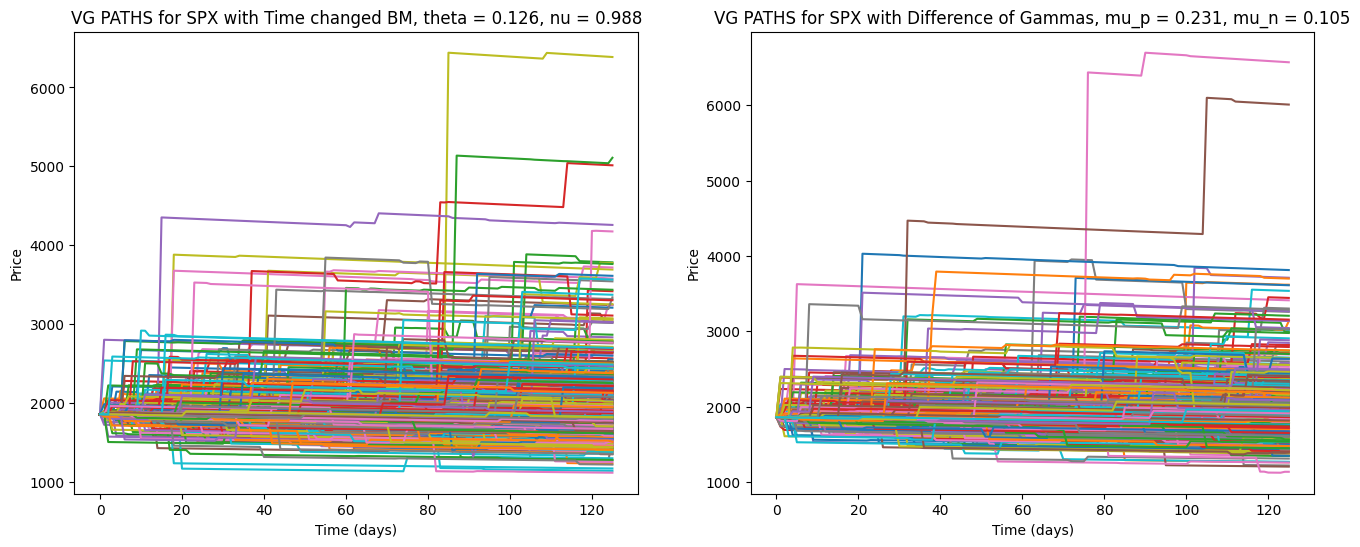

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [154]:
sigma, theta, nu = vg_params_calibrated

VG_CAL = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma_cal = VG_CAL.VarianceGammaPath1(days, paths)
SVarGamma2_cal = VG_CAL.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG_CAL.plotVGPath(SVarGamma_cal, symbol, method[0], ax=axes[0])
VG_CAL.plotVGPath(SVarGamma2_cal, symbol, method[1], ax=axes[1])
plt.tight_layout()

mu_p = 0.5 * np.sqrt(theta ** 2 + (2 * sigma ** 2 / nu)) + 0.5 * theta  # positive jump mean
mu_n = 0.5 * np.sqrt(theta ** 2 + (2 * sigma ** 2 / nu)) - 0.5 * theta  # negative jump mean
nu_p = mu_p ** 2 * nu  # positive jump variance
nu_n = mu_n ** 2 * nu  # negative jump variance

print('VG as Time changed brownian Motion. Parameters: ')
print(f'> Sigma = {sigma}\n> Theta = {theta}\n> Nu = {nu}')
print('VG as Time difference of gammas. Parameters: ')
print(f'> Mean Upward Jumps = {round(mu_p,3)}\n> Variance Upward Jumps = {round(nu_p,3)}')
print(f'> Mean Downward Jumps = {round(mu_n,3)}\n> Variance Downward Jumps = {round(nu_n,3)}')

### Option pricing with calibrated parameters
The following code snippet aims to find both Monte Carlo and Closed Formulas option prices for our **OTKO Daily Cliquet**.

In [155]:
calibrated_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'MKT_BID (%)': otko_spx['BID(%)'],
    'MKT_MID (%)': otko_spx['Midpoint (%)'],
    'MKT_ASK (%)': otko_spx['ASK(%)']
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 6 MONTHS. \n\n{calibrated_prices}')


MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 6 MONTHS. 

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0        0.085       0.0925         0.10
1  70   0        0.040       0.0450         0.05
2  85  75        0.170       0.1850         0.20
3  80  70        0.120       0.1300         0.14
4  90  80        0.240       0.2550         0.27


#### Merton Jump diffusion

In [156]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton_CAL.T:
        payoffs.append(MERT_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(calibrated_prices))
merton_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = MERT_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['MERTON MC (%)'] = merton_mc_prices
calibrated_prices['MERTON CF (%)'] = merton_cf_prices



#### Kou Jump Diffusion

In [157]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou_cal.T:
        payoffs.append(KOU_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(calibrated_prices))
kou_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = KOU_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['KOU MC (%)'] = kou_mc_prices
calibrated_prices['KOU CF (%)'] = kou_cf_prices

#### Variance Gamma

In [158]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma_cal.T:
        payoffs.append(VG_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(calibrated_prices))
vg_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    vg_cf_prices[index] = VG_CAL.closed_formula_otko5(strikes[index][0], strikes[index][1])

calibrated_prices['VG MC (%)'] = vg_mc_prices
calibrated_prices['VG CF (%)'] = vg_cf_prices

In [159]:
print(calibrated_prices)

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)   
0  75   0        0.085       0.0925         0.10       0.038124  \
1  70   0        0.040       0.0450         0.05       0.008682   
2  85  75        0.170       0.1850         0.20       0.201221   
3  80  70        0.120       0.1300         0.14       0.103034   
4  90  80        0.240       0.2550         0.27       0.299090   

   MERTON CF (%)  KOU MC (%)  KOU CF (%)  VG MC (%)  VG CF (%)  
0       0.077229    0.132284    0.105221   0.042505   0.051223  
1       0.036807    0.013896    0.061400   0.014004   0.021298  
2       0.180220    0.517094    0.174099   0.217941   0.220030  
3       0.110213    0.328984    0.112874   0.095957   0.097979  
4       0.273532    0.646308    0.261128   0.542369   0.490217  


### Calibration using Monte Carlo prices and matrices
In order to calibrate parameters without using any python library, a sort of **manual** calibration can be performed. To do so,a $(n+1)$-dimensional matrix is built, where n is the number of the parameters for each model. The $(n+1)-th$ dimension is needed to address the different strike couples.
#### Merton Jump Diffusion Monte Carlo Calibration

#### Kou Jump Diffusion Monte Carlo calibration

#### Variance Gamma process Monte Carlo Calibration


### VISUALIZE RESULTS